<a href="https://colab.research.google.com/github/krishnacnambiar/DSC_Intro/blob/master/malevsfemaleimageclassificationusingkeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification

## Set up

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import tensorflow_datasets as tfds

## Load the data: the Male vs Female dataset
### Delete Corrupt images

In [47]:
 import os

# num_skipped = 0
# for set_folder_name in ("Train","Validation"):
#     set_folder_path = os.path.join("/kaggle/input/gender-recognition-200k-images-celeba/Dataset/", set_folder_name)
#     for folder_name in ("Male", "Female"):
#         folder_path = os.path.join(set_folder_path, folder_name)
#         for fname in os.listdir(folder_path):
#             fpath = os.path.join(folder_path, fname)
#             fobj = open(fpath, "rb")
#             if tf.compat.as_bytes("JFIF") not in fobj.peek(10):
#                 num_skipped += 1
#                 # Delete corrupted image
#                 os.system("rm " + fpath)
# print("Deleted %d images" % num_skipped)

'/content'

### Generate Data Set

In [54]:
image_size = (180, 180)
batch_size = 32
train_dir = "./Dataset/Train"
validation_dir = "./Dataset/Validation"
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # Generator for our validation data

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=image_size,
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=image_size,
                                                              class_mode='binary')
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     "/kaggle/input/gender-recognition-200k-images-celeba/Dataset/Train",
# #     validation_split=0.2,
# #     subset="training",
#     seed=1337,
#     image_size=image_size,
#     batch_size=batch_size,
# )
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     "/kaggle/input/gender-recognition-200k-images-celeba/Dataset/Validation",
# #     validation_split=0.2,
# #     subset="validation",
#     seed=1337,
#     image_size=image_size,
#     batch_size=batch_size,
# )

Found 160000 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.


### Visualize the data

In [0]:
import matplotlib.pyplot as plt

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

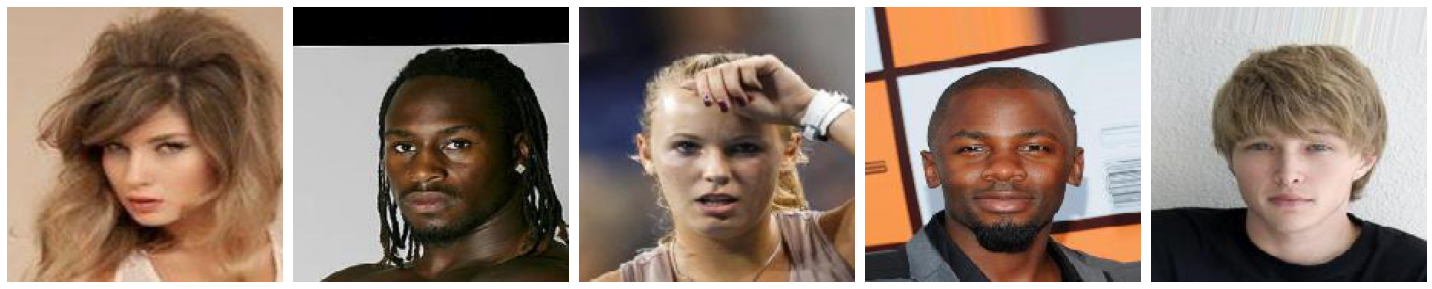

In [56]:
sample_train_images , _ = next(train_data_gen)
plotImages(sample_train_images)

## Build a model

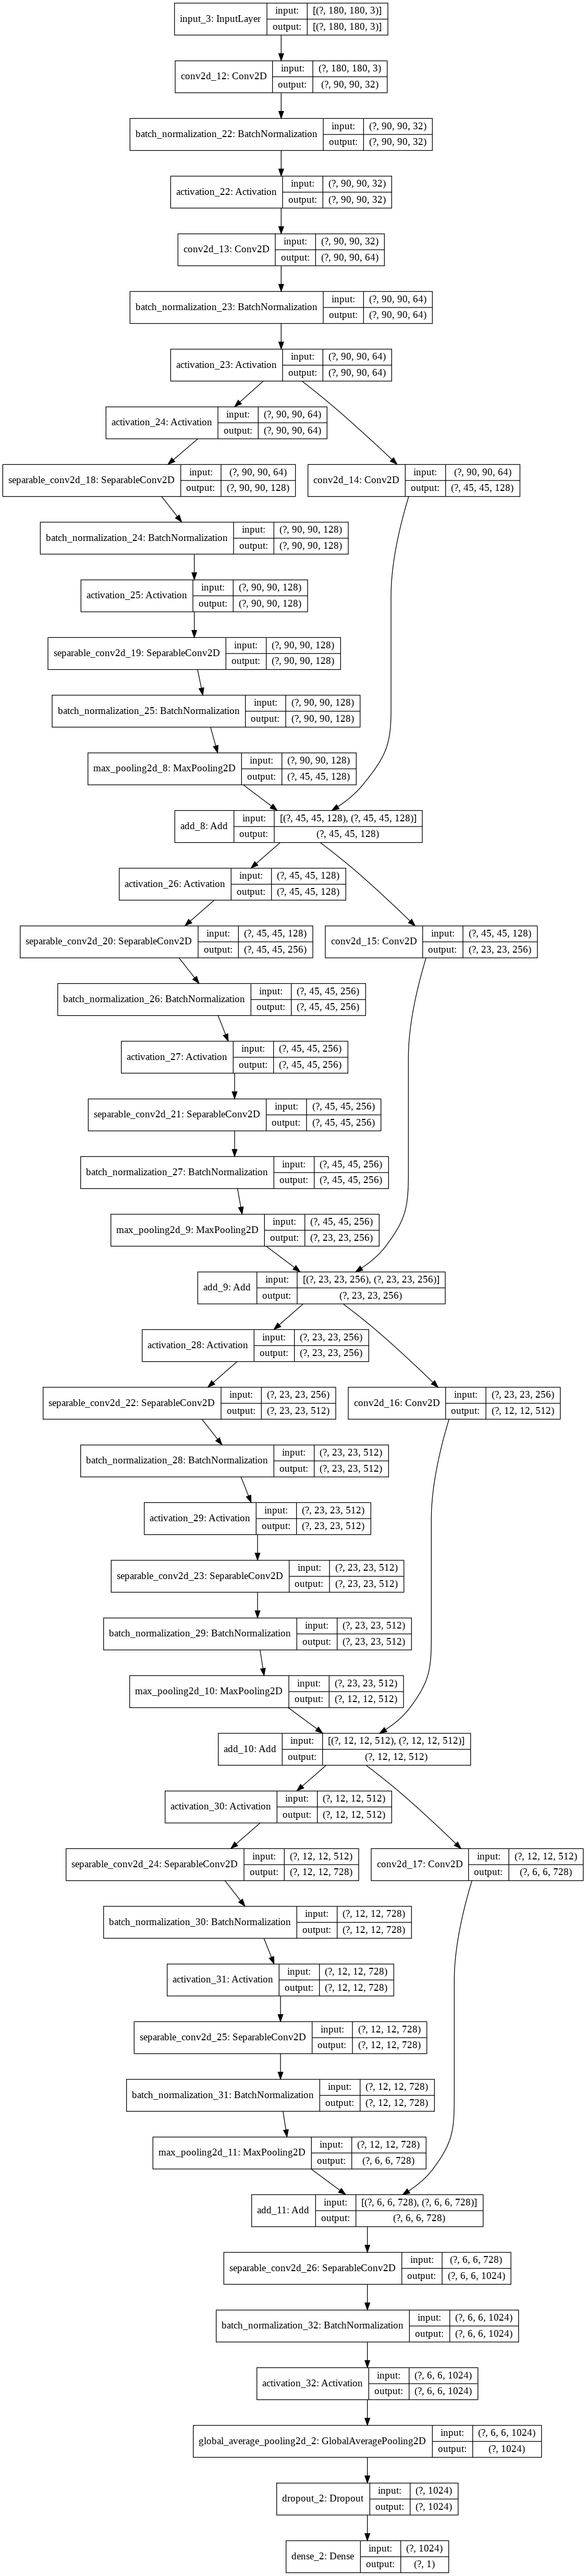

In [57]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
#     x = data_augmentation(inputs)

    # Entry block
#     x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [58]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_data_gen, epochs=epochs, callbacks=callbacks, validation_data=val_data_gen,)

Epoch 1/50
5000/5000 [==============================] - 913s 183ms/step - loss: 0.1255 - accuracy: 0.9504 - val_loss: 0.0878 - val_accuracy: 0.9666
Epoch 2/50
5000/5000 [==============================] - 911s 182ms/step - loss: 0.0734 - accuracy: 0.9734 - val_loss: 0.1020 - val_accuracy: 0.9574
Epoch 3/50
5000/5000 [==============================] - 909s 182ms/step - loss: 0.0594 - accuracy: 0.9786 - val_loss: 0.0688 - val_accuracy: 0.9722
Epoch 4/50
5000/5000 [==============================] - 910s 182ms/step - loss: 0.0510 - accuracy: 0.9821 - val_loss: 0.0668 - val_accuracy: 0.9787
Epoch 5/50
5000/5000 [==============================] - 907s 181ms/step - loss: 0.0443 - accuracy: 0.9843 - val_loss: 0.0648 - val_accuracy: 0.9777
Epoch 6/50
5000/5000 [==============================] - 909s 182ms/step - loss: 0.0380 - accuracy: 0.9866 - val_loss: 0.0534 - val_accuracy: 0.9803
Epoch 7/50
5000/5000 [==============================] - 912s 182ms/step - loss: 0.0327 - accuracy: 0.9884 - val_

KeyboardInterrupt: ignored

In [0]:
model.save("model.h5")
model.save_weights("model_weights.h5")

## Test set prediction

In [60]:
image_size = (180, 180)
batch_size = 32
test_dir = "./Dataset/Test"

test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # Generator for our test data

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=test_dir,
                                                           shuffle=True,
                                                           target_size=image_size,
                                                           class_mode='binary')

Found 20001 images belonging to 2 classes.


In [0]:
from keras.models import load_model
model = load_model('/content/model.h5')

In [66]:

filepath = '/content/Dataset/Test/Male/160026.jpg'
# filepath = "/content/Dataset/Test/Female/160001.jpg"
img = keras.preprocessing.image.load_img(
    filepath, target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis


predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent Female and %.2f percent Male."
    % (100 * (1 - score), 100 * score)
)

This image is 100.00 percent Female and 0.00 percent Male.
